## 대회 소개

- 출처 : 캐글
  - 문제 제공자 : IEEE Computational Intelligence Society
- 문제 개요: 카드 기록을 활용한 사기 거래 탐지
- 대부분 컬럼이 비식별화되어 있어, 이전 문제와 다르게 데이터 탐색을 통한 데이터에 대한 이해가 매우 중요

## 사용 데이터
- train.csv: 모델 학습용 데이터(데이터가 커서 샘플링된 데이터 제공)/ test.csv: 모델 평가용 데이터
  - TransactionID: 거래 ID(비식별화)
  - TransactionDT: 거래 시각(비식별화)
  - TransactionAmt: 거래 금액(US Dollar)
  - ProductCD: 상품 코드
  - card1 - card6: 카드 관련 정보(비식별화)
  - P_emaildomain, R_emaildomain: 이메일 정보
  - M1 - M9: 기존 거래와의 매칭 정보
  - isFraud: 사기 거래 여부

## 사용 데이터의 특징
- 비식별화된 특징이 매우 많음
- 다수 결측이 포함되어 있음
- 클래스 불균형 문제 존재

## 1. 데이터 분리
- df: sampled_train_transaction.csv
- 'TransactionID', 'TransactionDT' 변수는 삭제
- X: df에서 isFraud가 제거된 데이터 프레임
- Y: df에서 isFraud값만 가져온 Series

In [2]:
import os
import pandas as pd
import numpy as np
os.chdir(r'C:\Users\신상훈\Desktop\preprocessing\part-6.-실전-머신러닝-프로젝트\6. 실전 머신러닝 프로젝트\25. IEEE-CIS Fraud Detection\데이터')

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (20, 5)

import warnings
warnings.filterwarnings('ignore')

#### 1.1 데이터 불러오기 및 불필요한 변수 삭제

In [3]:
df = pd.read_csv('sampled_train_transaction.csv')

In [4]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,1.0,T,T,T,M2,F,T,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,1.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,1.0,T,T,T,M0,F,F,F,F,F
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,1.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.drop(['TransactionID','TransactionDT'], axis = 1, inplace = True)

#### 1.2 데이터 분리

In [6]:
X = df.drop(['isFraud'], axis = 1)
Y = df['isFraud']

from sklearn.model_selection import train_test_split
Train_X , Test_X, Train_Y, Test_Y = train_test_split(X, Y)

## 2. 변수 탐색

#### 2.1 라벨 확인
- 사기 거래가 아닌 거래가 전체 거래의 97.4%를 차지
- 클래스 불균형 문제가 발생할 확률이 매우 높아보임

In [8]:
Train_Y.value_counts(normalize = True)

0    0.974147
1    0.025853
Name: isFraud, dtype: float64

In [9]:
Train_Y.value_counts(normalize = False)

0    73061
1     1939
Name: isFraud, dtype: int64

#### 2.2 변수별 상태 공간 확인: 컬럼별 유니크한 값 일부 확인

탐색 내용 <br>
- TransactionAmt는 연속형 변수임이 확실해보임 (히스토그램 등으로 확인)
- ProductCD, card4, card6은 범주형 변수임이 확실해보임 (결측 포함)
- P_emaildomain, R_emaildomain은 구매자의 이메일 도메인으로 보임. 직관적으로 봤을 때, 유의한 의미가 있을지 의심되며, 둘은 관계가 있을 것으로 보임
- card1, card2, card3, card5은 연속형 변수임이 확실해보임 (히스토그램 등으로 확인)
- 많은 변수에서 결측이 포함되어 있음
- C3를 제외한 C1 ~ C14는 모두 연속형 변수인 것으로 보임. 비식별화되어 있어 대략적인 의미라도 추측을 해야 함
- 결측이 매우 많아, 곧바로 대체하기에는 부담이 있어, 결측 분포 확인 필요
- M1 ~ M9는 매칭 정보이며, 전부 범주형 변수임이 확실함. T는 매칭됨, F는 매칭되지 않음을 나타내는 것으로 보이며, 모두 결측이 포함

In [11]:
for col in Train_X.columns:
        print("변수: {}, 타입: {}, 결측 개수: {}, 상태공간 크기: {}, 상태공간 일부: {}".format(col, Train_X[col].dtype, Train_X[col].isnull().sum(), len(Train_X[col].unique()), Train_X[col].unique()[:5]))

변수: TransactionAmt, 타입: float64, 결측 개수: 0, 상태공간 크기: 5491, 상태공간 일부: [ 50. 527. 200.  49.  20.]
변수: ProductCD, 타입: object, 결측 개수: 0, 상태공간 크기: 5, 상태공간 일부: ['H' 'W' 'R' 'S' 'C']
변수: card1, 타입: int64, 결측 개수: 0, 상태공간 크기: 6872, 상태공간 일부: [11862  5613 11207  9500 13780]
변수: card2, 타입: float64, 결측 개수: 1004, 상태공간 크기: 500, 상태공간 일부: [562. 413. 361. 321. 298.]
변수: card3, 타입: float64, 결측 개수: 3, 상태공간 크기: 73, 상태공간 일부: [150. 185. 144. 119. 134.]
변수: card4, 타입: object, 결측 개수: 7, 상태공간 크기: 5, 상태공간 일부: ['visa' 'mastercard' 'discover' 'american express' nan]
변수: card5, 타입: float64, 결측 개수: 382, 상태공간 크기: 82, 상태공간 일부: [226. 166. 117. 202. 219.]
변수: card6, 타입: object, 결측 개수: 3, 상태공간 크기: 5, 상태공간 일부: ['credit' 'debit' 'debit or credit' 'charge card' nan]
변수: P_emaildomain, 타입: object, 결측 개수: 11558, 상태공간 크기: 59, 상태공간 일부: ['gmail.com' nan 'anonymous.com' 'aol.com' 'att.net']
변수: R_emaildomain, 타입: object, 결측 개수: 49050, 상태공간 크기: 60, 상태공간 일부: [nan 'optonline.net' 'mail.com' 'anonymous.com' 'aol.com']
변수: C1, 타입: float

#### 2.3 탐색을 위한 데이터 준비: 특징과 라벨 데이터 병합

In [12]:
Train_df = pd.concat([Train_X, Train_Y], axis = 1)
Train_df.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,P_emaildomain,R_emaildomain,...,M1,M2,M3,M4,M5,M6,M7,M8,M9,isFraud
76354,50.0,H,11862,562.0,150.0,visa,226.0,credit,gmail.com,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
33376,527.0,W,5613,413.0,150.0,visa,166.0,debit,NaN,NaN,...,T,T,F,M0,T,F,NaN,NaN,NaN,0
41707,200.0,H,11207,361.0,150.0,visa,226.0,debit,gmail.com,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
80657,49.0,W,9500,321.0,150.0,visa,226.0,debit,gmail.com,NaN,...,T,T,T,M0,F,F,NaN,NaN,NaN,0
23231,20.0,W,13780,298.0,150.0,visa,226.0,debit,gmail.com,NaN,...,NaN,NaN,NaN,M0,F,T,NaN,NaN,NaN,0


#### 2.4 범주형 변수 탐색
(1) 결측을 문자로 변환 (탐색을 위해 임시 변환) <br>
(2) 변수별 분포 확인 (bar plot) <br>
(3) 변수와 특징 간 관계 확인 (groupby)

2.4.1 ProductCD

In [13]:
Train_df['ProductCD'].isnull().sum()

0

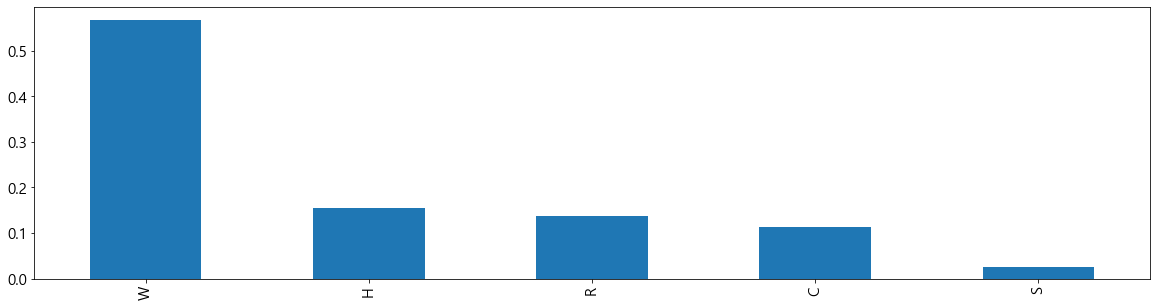

In [14]:
Train_df['ProductCD'].value_counts(normalize = True).plot(kind = 'bar') # value_counts에 대한 bar plot 생성
# ProductCD가 W가 매우 높은 비율을 차지하며, S는 1% 가량됨을 확인

In [15]:
# 상품별로 차이가 존재함을 확인 (다만, H와 W는 거의 유사하다고 판단됨)
# 상태 공간의 크기가 그리 크지 않으니, 굳이 변수 값의 군집화는 수행하지 않고 더미화를 하기로 결정
Train_df.groupby('ProductCD')['isFraud'].mean()

ProductCD
C    0.087336
H    0.019801
R    0.011186
S    0.023597
W    0.018951
Name: isFraud, dtype: float64

2.4.2 card4

In [17]:
Train_df['card4'].isnull().sum() # 결측이 7개밖에 되지 않음 ==> 전부 최빈값으로 대체

7

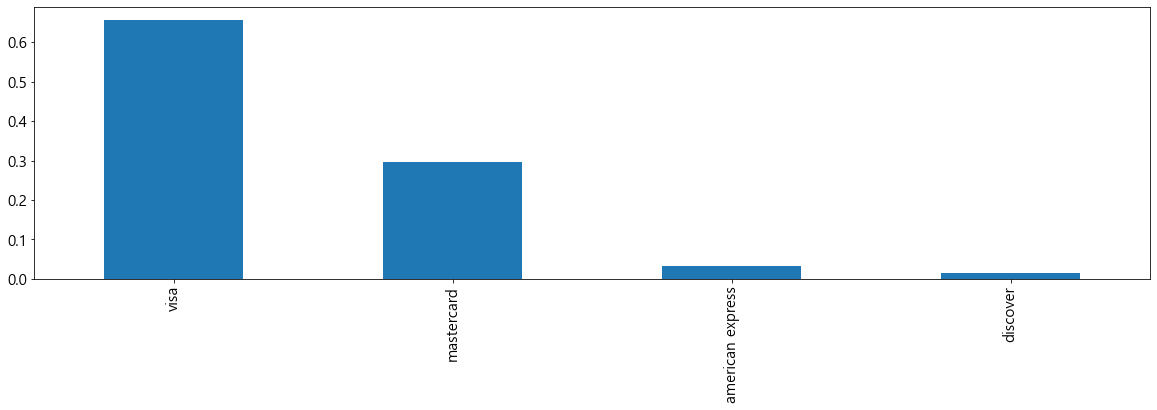

In [18]:
Train_df['card4'].value_counts(normalize = True).plot(kind = 'bar') # value_counts에 대한 bar plot 생성
# visa와 master card가 매우 높은 비율을 차지하며, discover는 거의 발생하지 않음

In [19]:
# 거래의 대다수를 차지하는 visa와 mastercard의 값이 유사
# american express만 유독 값이 작으며 해당 값의 빈도가 높지 않음 => 해당 변수를 american express란 변수로 이진화
# 따라서 결측을 특별히 제거할 필요가 없음
Train_df.groupby('card4')['isFraud'].mean()

card4
american express    0.012034
discover            0.026412
mastercard          0.029062
visa                0.025057
Name: isFraud, dtype: float64

2.4.3 card6

In [21]:
Train_df['card6'].isnull().sum() # 결측이 3개밖에 되지 않음 ==> 전부 최빈값으로 대체

3

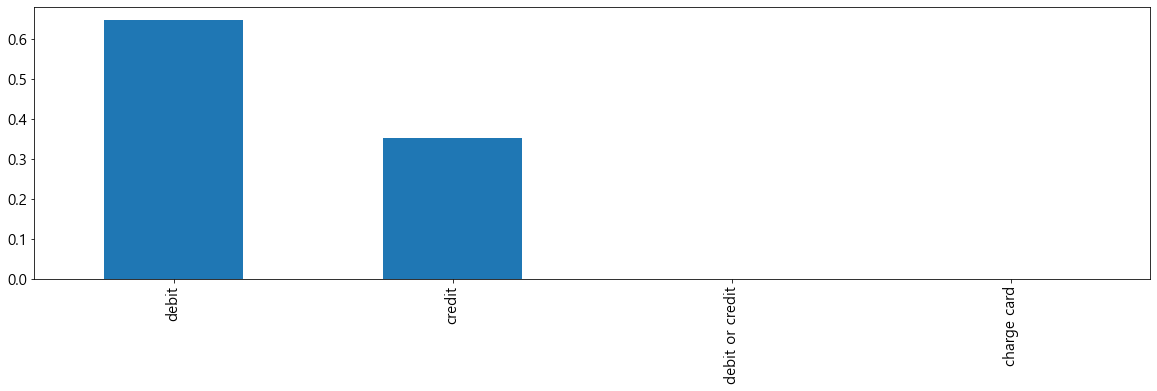

In [22]:
Train_df['card6'].value_counts(normalize = True).plot(kind = 'bar') # value_counts에 대한 bar plot 생성
# debit과 credit이 대다수를 차지. 다른 값들은 육안으로 확인이 불가능한 수준

In [23]:
Train_df['card6'].value_counts(normalize = False) # debit or credit, charge card는 빈도가 매우 적음

debit              48615
credit             26373
debit or credit        7
charge card            2
Name: card6, dtype: int64

In [24]:
# credit과 debit의 차이가 존재
# charge card, debit or credit은 전부 0임을 확인 ==> 그러나 빈도 자체가 매우 적어서 그런 것이라 예상됨
# 따라서 credit인지 나타내는 변수로만 변환
Train_df.groupby('card6')['isFraud'].mean()

card6
charge card        0.000000
credit             0.036249
debit              0.020179
debit or credit    0.000000
Name: isFraud, dtype: float64

2.4.4 P_emaildomain과 R_emaildomain

- 이전 탐색에서 각각의 상태 공간 크기가 60, 61임을 확인 (대다수가 gmail 혹은 yahoo 메일임)
- 또한, 결측이 매우 많았는데, email이 결측이라는 것이 어떤 의미가 있을것이라 의심됨
- 샘플의 개수를 고려하더라도 그 크기가 큰 범주형 변수라고 판단 가능
- 두 변수간 관계가 있으리라 쉽게 판단 가능
- 또한, .를 기준으로 앞쪽에는 실제 도메인이, 뒤쪽에는 com, net 등이 포함되어 있어 분할 필요

In [25]:
Train_df['P_emaildomain'].value_counts()

gmail.com           27234
yahoo.com           11927
anonymous.com        6511
hotmail.com          6043
aol.com              3657
comcast.net          1371
icloud.com            669
msn.com               643
outlook.com           579
att.net               531
sbcglobal.net         499
verizon.net           473
live.com              366
bellsouth.net         326
me.com                283
ymail.com             281
cox.net               275
yahoo.com.mx          221
charter.net           178
optonline.net         152
live.com.mx           101
mac.com                96
rocketmail.com         82
earthlink.net          68
mail.com               59
roadrunner.com         57
juno.com               51
embarqmail.com         50
outlook.es             44
twc.com                41
gmail                  40
windstream.net         38
netzero.com            36
q.com                  34
hotmail.es             34
frontier.com           32
aim.com                30
web.de                 29
cfl.rr.com  

In [26]:
Train_df['R_emaildomain'].value_counts()

gmail.com           9821
anonymous.com       5210
hotmail.com         4049
yahoo.com           2445
aol.com              999
comcast.net          581
outlook.com          325
icloud.com           242
msn.com              235
yahoo.com.mx         221
verizon.net          184
sbcglobal.net        173
cox.net              162
me.com               149
bellsouth.net        136
att.net              130
live.com             124
live.com.mx          101
optonline.net         55
mac.com               49
ymail.com             46
outlook.es            43
hotmail.es            34
mail.com              33
charter.net           32
web.de                28
hotmail.fr            26
embarqmail.com        24
prodigy.net.mx        23
earthlink.net         22
yahoo.fr              19
frontier.com          17
juno.com              16
rocketmail.com        15
roadrunner.com        15
cfl.rr.com            14
q.com                 13
gmx.de                13
suddenlink.net        12
twc.com               11


In [27]:
# 결측이 의미가 있는지 확인 (두 변수 모두 결측이 많다는 것은 위에서 확인함)
# 결측을 나타내는 변수 생성
Train_df['NA_P_emaildomain'] = Train_df['P_emaildomain'].isnull().astype(int)
Train_df['NA_R_emaildomain'] = Train_df['R_emaildomain'].isnull().astype(int)

In [28]:
Train_df['NA_P_emaildomain']

76354    0
33376    1
41707    0
80657    0
23231    0
        ..
73776    0
78629    0
66768    0
10307    0
29136    1
Name: NA_P_emaildomain, Length: 75000, dtype: int32

In [29]:
# P_emaildomain은 크게 문제 없어보임
Train_df.groupby('NA_P_emaildomain')['isFraud'].mean()

NA_P_emaildomain
0    0.026307
1    0.023360
Name: isFraud, dtype: float64

In [30]:
# R_emaildomain은 오히려 결측이 발생하지 않았을 때 사기인 경우가 더 많음을 확인 ==> 변수로 활용
Train_df.groupby('NA_R_emaildomain')['isFraud'].mean()

NA_R_emaildomain
0    0.041272
1    0.017696
Name: isFraud, dtype: float64

In [31]:
# 유의한 도메인만 가져와서 추가 탐색 수행
Train_df['P_emaildomain'] = Train_df['P_emaildomain'].str.split('.', expand = True).iloc[:, 0]
Train_df['R_emaildomain'] = Train_df['R_emaildomain'].str.split('.', expand = True).iloc[:, 0]

In [32]:
# P_emaildomain에 따른 isFraud의 평균 차이가 존재함
# 다만, cableone.net 등은 그 빈도가 매우 적어서 이 차이가 유의한 것인지 판단이 불가
Train_df.groupby('P_emaildomain')['isFraud'].mean()

P_emaildomain
aim             0.033333
anonymous       0.010290
aol             0.015313
att             0.011299
bellsouth       0.003067
cableone        0.000000
centurylink     0.000000
cfl             0.000000
charter         0.005618
comcast         0.010212
cox             0.003636
earthlink       0.000000
embarqmail      0.000000
frontier        0.000000
frontiernet     0.142857
gmail           0.035492
gmx             0.000000
hotmail         0.045990
icloud          0.038864
juno            0.000000
live            0.019190
mac             0.000000
mail            0.118644
me              0.024735
msn             0.013997
netzero         0.000000
optonline       0.000000
outlook         0.065811
prodigy         0.000000
protonmail      0.250000
ptd             0.000000
q               0.000000
roadrunner      0.000000
rocketmail      0.000000
sbcglobal       0.000000
sc              0.000000
servicios-ta    0.000000
suddenlink      0.000000
twc             0.000000
verizon    

In [33]:
# P_emaildomain에 따른 isFraud의 평균 차이가 존재함
# 다만, 대다수 값이 그 빈도가 매우 적어서 이 차이가 유의한 것인지 판단이 불가
Train_df.groupby('R_emaildomain')['isFraud'].mean()

R_emaildomain
aim             0.250000
anonymous       0.008829
aol             0.009009
att             0.000000
bellsouth       0.000000
cableone        0.000000
centurylink     0.000000
cfl             0.000000
charter         0.000000
comcast         0.017212
cox             0.012346
earthlink       0.000000
embarqmail      0.000000
frontier        0.000000
frontiernet     0.000000
gmail           0.062665
gmx             0.000000
hotmail         0.062242
icloud          0.049587
juno            0.000000
live            0.000000
mac             0.000000
mail            0.060606
me              0.000000
msn             0.000000
netzero         0.000000
optonline       0.000000
outlook         0.097826
prodigy         0.000000
protonmail      0.500000
ptd             0.000000
q               0.000000
roadrunner      0.000000
rocketmail      0.000000
sbcglobal       0.000000
sc              0.000000
scranton        0.000000
servicios-ta    0.000000
suddenlink      0.000000
twc        

In [34]:
# 같은 거래라면 P_emaildomain과 R_emaildomain이 특정 관계가 있지 않을까?
# 파생 변수 추가 및 확인: 실제 라벨의 분포를 고려했을 때, 1%와 5%의 차이는 꽤 큰 것이라 예상됨 ==> 해당 변수 사용
Train_df['same_emaildomain'] = (Train_df['P_emaildomain'] == Train_df['R_emaildomain']).astype(int)
print(Train_df['same_emaildomain'].value_counts())
print('\n')
print(Train_df.groupby('same_emaildomain')['isFraud'].mean())

0    56151
1    18849
Name: same_emaildomain, dtype: int64


same_emaildomain
0    0.017132
1    0.051833
Name: isFraud, dtype: float64


2.4.5 C3

In [35]:
# 결측이 없음을 이전에서 확인
# 변수 타입은 float인데, 상태 공간의 크기가 크지 않음 ==> 일단은 범주형으로 보는 것이 적절할 것 같음

In [36]:
# 0.0 값이 대다수임을 확인
Train_df['C3'].value_counts(normalize = True)

0.0    0.988627
1.0    0.010587
2.0    0.000667
3.0    0.000080
9.0    0.000013
8.0    0.000013
4.0    0.000013
Name: C3, dtype: float64

In [37]:
Train_df['C3'].value_counts(normalize = False)

0.0    74147
1.0      794
2.0       50
3.0        6
9.0        1
8.0        1
4.0        1
Name: C3, dtype: int64

In [38]:
# 2.0 이상의 값은 거의 존재하지 않기 때문에, 우연히 평균이 0이 나왔을 것이란 추측이 가능
# 0.0은 자주 등장했기 때문에, 라벨의 평균과 유사
# 1.0은 빈도가 어느정도 있음에도 불구하고 라벨의 평균과 크게 다름
# (조금은 위험한) 가설 수립: C3값이 1 이상인지 아닌지에 따른 차이가 존재할 것이다! => C3_over_1 변수 생성
Train_df.groupby('C3')['isFraud'].mean()

C3
0.0    0.026137
1.0    0.001259
2.0    0.000000
3.0    0.000000
4.0    0.000000
8.0    0.000000
9.0    0.000000
Name: isFraud, dtype: float64

In [39]:
Train_Y.value_counts(normalize = True)

0    0.974147
1    0.025853
Name: isFraud, dtype: float64

2.4.6 M 관련 변수
- M1 - M9는 결측도 절반가까이를 포함하여, 대체하는 것은 어려을 것으로 예상됨
- 모두 범주형 변수이며, 값의 출현 패턴이 유사하니 동시에 탐색 수행

In [40]:
# 탐색을 위해, 모든 결측값을 우선 대체
M_columns = ['M' + str(i) for i in range(1, 10)]
Train_df[M_columns] = Train_df[M_columns].fillna("결측")

In [41]:
## 변수 분포 확인
# 1. 결측이 매우 많음 => 단순 대체 및 제거 불가
# 2. M4를 제외하고는 T (True), F (False로 정의됨)
for col in M_columns:
    print(Train_df[col].value_counts())
    print('\n')

결측    51484
T     23516
Name: M1, dtype: int64


결측    51484
T     21139
F      2377
Name: M2, dtype: int64


결측    51484
T     18357
F      5159
Name: M3, dtype: int64


결측    43298
M0    19663
M2     7022
M1     5017
Name: M4, dtype: int64


결측    51700
F     12933
T     10367
Name: M5, dtype: int64


결측    34231
F     21899
T     18870
Name: M6, dtype: int64


결측    63033
F     10287
T      1680
Name: M7, dtype: int64


결측    63033
F      7406
T      4561
Name: M8, dtype: int64


결측    63033
T     10252
F      1715
Name: M9, dtype: int64




In [42]:
## 변수 값별 라벨 확인: 값별로 차이가 있으며, 결측 자체로도 의미가 있어보임
# 결측으로 대체 후 더미화 필요
for col in M_columns:
    print(Train_df.groupby(col)['isFraud'].mean())
    print('\n')

M1
T     0.017222
결측    0.029796
Name: isFraud, dtype: float64


M2
F     0.033235
T     0.015422
결측    0.029796
Name: isFraud, dtype: float64


M3
F     0.028688
T     0.014000
결측    0.029796
Name: isFraud, dtype: float64


M4
M0    0.036719
M1    0.022125
M2    0.086158
결측    0.011571
Name: isFraud, dtype: float64


M5
F     0.020722
T     0.042732
결측    0.023752
Name: isFraud, dtype: float64


M6
F     0.024476
T     0.013514
결측    0.033537
Name: isFraud, dtype: float64


M7
F     0.013415
T     0.007738
결측    0.028366
Name: isFraud, dtype: float64


M8
F     0.013773
T     0.010743
결측    0.028366
Name: isFraud, dtype: float64


M9
F     0.013994
T     0.012388
결측    0.028366
Name: isFraud, dtype: float64




#### 2.5 연속형 변수 탐색
(1) 변수별 분포 확인 (히스토그램) <br>
(2) 변수와 라벨 간 관계 파악 (박스플롯)

2.5.1 TransactionAmt

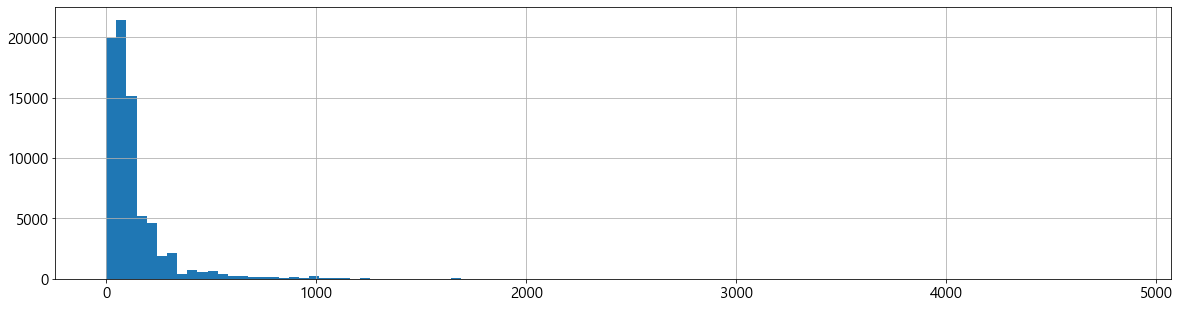

In [43]:
# 히스토그램 생성: 대다수가 1000달러 이하임을 확인 (거기다가 굉장히 치우침을 확인)
Train_df['TransactionAmt'].hist(bins = 100)

In [44]:
# 한쪽에 매우 치우침을 확인함: 거래 금액이 매우 크거나 작은 것 자체가 특징이 되지 않을까?
Train_df['TransactionAmt'].describe()

count    75000.000000
mean       130.992244
std        206.867419
min          0.292000
25%         45.000000
50%         75.000000
75%        139.950000
max       4829.950000
Name: TransactionAmt, dtype: float64

([<matplotlib.axis.XTick at 0x28c8bae3eb0>,
 [Text(0, 0, 'Fraud'), Text(0, 0, 'not Fraud')])

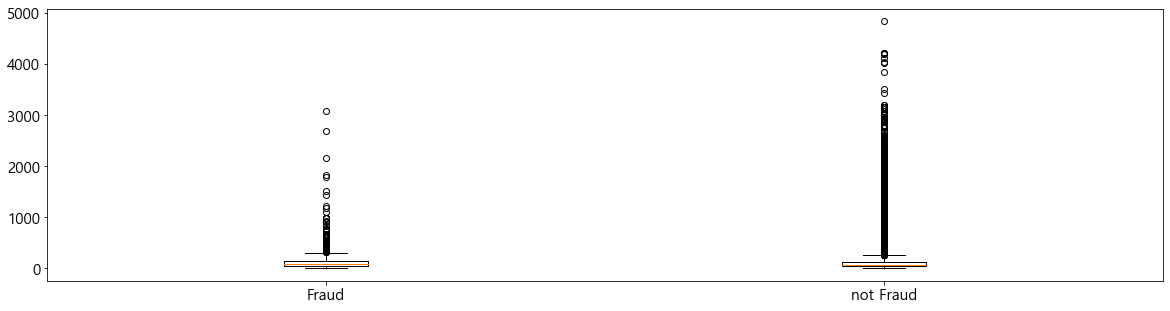

In [45]:
TransactionAmt_Fraud = Train_df['TransactionAmt'].loc[Train_df['isFraud'] == 1]
TransactionAmt_not_Fraud = Train_df['TransactionAmt'].loc[Train_df['isFraud'] == 0]

# 대부분 이상치로 판단되어 정상적인 해석이 쉽지 않음 (다만, Fraud인 경우의 범위가 더 좁음)
plt.boxplot([TransactionAmt_Fraud, TransactionAmt_not_Fraud])
plt.xticks([1, 2], ['Fraud', 'not Fraud'])

In [46]:
# 사기 거래의 경우
TransactionAmt_Fraud.describe()

count    1939.000000
mean      133.166159
std       184.710207
min         0.292000
25%        40.810000
50%        80.000000
75%       150.000000
max      3081.970000
Name: TransactionAmt, dtype: float64

In [47]:
# 사기 거래가 아닌 경우
TransactionAmt_not_Fraud.describe()

count    73061.000000
mean       130.934550
std        207.424044
min          1.251000
25%         45.000000
50%         75.000000
75%        135.580000
max       4829.950000
Name: TransactionAmt, dtype: float64

In [ ]:
# 특별한 관계를 찾기는 어려움: 또한, 사기 거래인 경우에는 데이터가 많아서 범위가 커보일 수 있음 
# 따라서 라벨과 관계를 고려하지 않고, 치우침만 해결하기로 결정

2.5.2 C 관련 변수 (C3 제외)

In [48]:
# 변수 목록 생성
C_columns = ['C' + str(i) for i in range(1, 15) if i != 3]
C_columns

['C1',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14']

In [49]:
# 대다수의 변수가 75%값은 10미만인데, max값은 매우 큼 ==> 이상하다?
Train_df[C_columns].describe()

,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.00000
mean,40.721493,47.428547,19.016613,4.100160,22.987627,15.681067,25.890973,3.261520,26.451813,29.468467,21.970787,45.021773,16.86408
std,310.883923,362.265837,157.506317,21.243239,158.269992,150.555406,230.451690,13.981274,231.128642,217.378980,211.332978,219.952507,103.49375
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.00000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,1.00000
75%,2.000000,2.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,9.000000,2.00000
max,4685.000000,5691.000000,2253.000000,295.000000,2253.000000,2255.000000,3331.000000,194.000000,3257.000000,3188.000000,3188.000000,2918.000000,1429.00000


In [50]:
# 상위 90% 값 확인
Train_df[C_columns].quantile(0.90)

C1      6.0
C2      6.0
C4      1.0
C5      2.0
C6      4.0
C7      1.0
C8      1.0
C9      3.0
C10     1.0
C11     4.0
C12     1.0
C13    33.0
C14     5.0
Name: 0.9, dtype: float64

In [51]:
# 상위 95%값 확인
Train_df[C_columns].quantile(0.95)

C1      44.00
C2      47.05
C4       2.00
C5       5.00
C6      27.00
C7       1.00
C8       2.00
C9       6.00
C10      2.00
C11     29.00
C12      1.00
C13    152.00
C14     25.00
Name: 0.95, dtype: float64

In [52]:
# 상위 99%값 확인
Train_df[C_columns].quantile(0.99)

C1     1179.01
C2     1481.00
C4      813.00
C5      134.00
C6      818.01
C7      616.01
C8      892.01
C9       82.00
C10    1022.01
C11     922.01
C12     846.01
C13     883.00
C14     567.00
Name: 0.99, dtype: float64

In [ ]:
# C 관련 변수는 모두 치우침이 매우 심각함
# 상위 95%값과 99% 값의 차이가 너무 많이 남
# 변수로 활용하기 어려워보임 ==> 이진화를 하기에는 자르는 구간 설정이 어려움 ==> 해당 특징을 사용하려면 트리 계열 모델 사용이 필수적

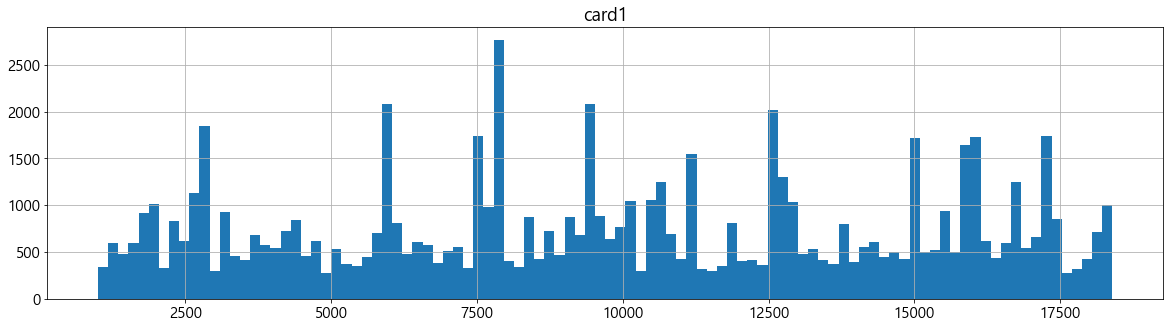

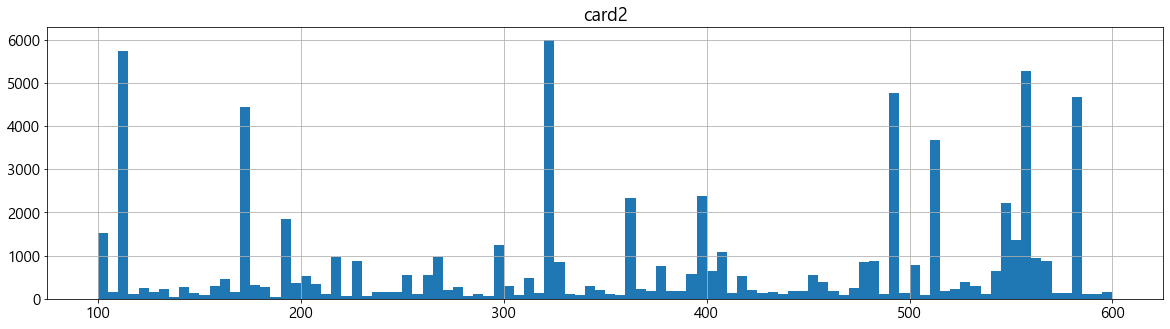

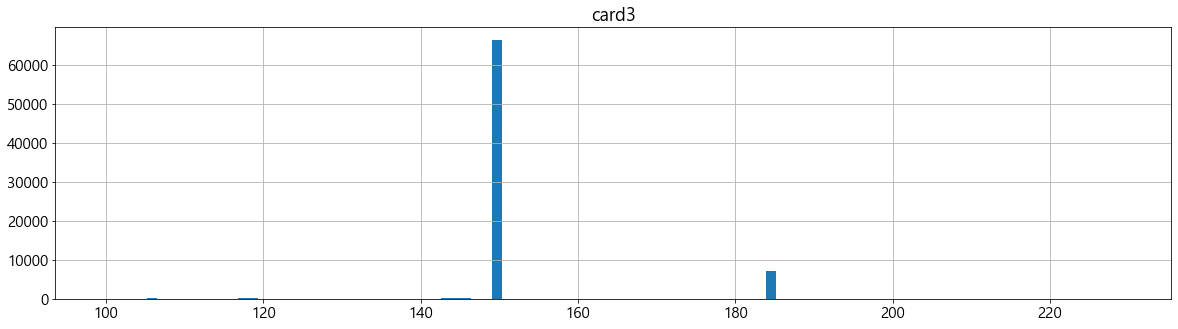

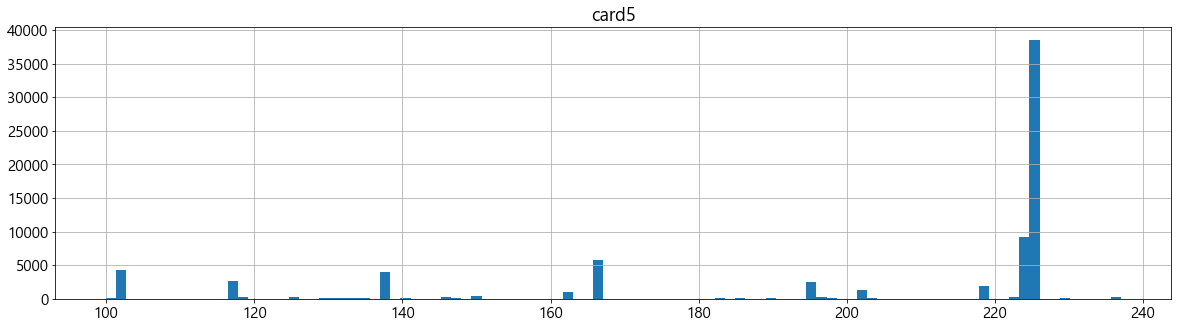

In [53]:
# 히스토그램 확인: card3과 card5의 분포가 특이함 (치우침이 특정 방향으로 일어나지는 않았음. 사실상 범주 변수로 보는 것이 바람직)
# 연속형 변수로 간주할 수 있는 card1과 card3은 결측 처리 필요
card_columns = ['card1', 'card2', 'card3', 'card5']
for col in card_columns:
    plt.title(col)
    Train_df[col].hist(bins = 100)
    plt.show()

In [54]:
# 값의 분포 확인
Train_df[card_columns].describe()

,card1,card2,card3,card5
count,75000.000000,73996.000000,74997.000000,74618.000000
mean,9876.058440,370.601289,153.221502,200.093610
std,4936.287258,159.455608,11.160047,40.894676
min,1004.000000,100.000000,100.000000,100.000000
25%,6019.000000,215.000000,150.000000,166.000000
50%,9692.000000,387.000000,150.000000,226.000000
75%,14276.000000,514.000000,150.000000,226.000000
max,18395.000000,600.000000,229.000000,237.000000


In [55]:
Train_df['card3'].value_counts() # 150인지, 185인지 아닌지를 나타내는 변수로 변환 필요

150.0    66509
185.0     7211
144.0      207
106.0      142
146.0      127
         ...  
127.0        1
208.0        1
109.0        1
152.0        1
186.0        1
Name: card3, Length: 72, dtype: int64

In [56]:
Train_df['card3_150'] = (Train_df['card3'] == 150).astype(int)
Train_df['card3_185'] = (Train_df['card3'] == 185).astype(int)

In [57]:
Train_df.groupby('card3_150')['isFraud'].mean() # 차이가 있음을 확인

card3_150
0    0.085031
1    0.018298
Name: isFraud, dtype: float64

In [58]:
Train_df.groupby('card3_185')['isFraud'].mean() # 차이가 있음을 확인

card3_185
0    0.018204
1    0.097767
Name: isFraud, dtype: float64

In [59]:
Train_df['card5'].value_counts() # 226인지 아닌지를 나타내는 변수로 변환 필요

226.0    38525
224.0     9150
166.0     5739
102.0     4303
117.0     2686
         ...  
189.0        1
206.0        1
184.0        1
171.0        1
201.0        1
Name: card5, Length: 81, dtype: int64

In [60]:
Train_df['card5_226'] = (Train_df['card5'] == 226).astype(int)

In [61]:
Train_df.groupby('card5_226')['isFraud'].mean() # 차이가 있음을 확인

card5_226
0    0.030377
1    0.021570
Name: isFraud, dtype: float64

## 3. 데이터 전처리

#### 3.1 이진화

card4 이진화

In [62]:
Train_X['american_express'] = (Train_X.loc[:,'card4'] == 'american express').astype(int)
Train_X.drop('card4', axis = 1, inplace = True)

In [63]:
Test_X['american_express'] = (Test_X.loc[:, 'card4'] == 'american express').astype(int)
Test_X.drop('card4', axis = 1, inplace = True)

card6 이진화

In [64]:
Train_X['credit'] = (Train_X.loc[:, 'card6'] == 'credit').astype(int)
Train_X.drop('card6', axis = 1, inplace = True)

In [65]:
Test_X['credit'] = (Test_X.loc[:, 'card6'] == 'credit').astype(int)
Test_X.drop('card6', axis = 1, inplace = True)

same_email 변수 추가 및 기존 변수 삭제

In [66]:
Train_X['NA_R_emaildomain'] = (Train_X['R_emaildomain'].isnull()).astype(int)
Train_X['same_emaildomain'] = (Train_X['P_emaildomain'] == Train_X['R_emaildomain']).astype(int)
Train_X.drop(['P_emaildomain', 'R_emaildomain'], axis = 1, inplace = True)

In [67]:
Test_X['NA_R_emaildomain'] = (Test_X['R_emaildomain'].isnull()).astype(int)
Test_X['same_emaildomain'] = (Test_X['P_emaildomain'] == Test_X['R_emaildomain']).astype(int)
Test_X.drop(['P_emaildomain', 'R_emaildomain'], axis = 1, inplace = True)

C3_over_1 변수 생성

In [68]:
Train_X['C3_over_1'] = (Train_X['C3'] >= 1).astype(int)
Train_X.drop(['C3'], axis = 1, inplace = True)

In [69]:
Test_X['C3_over_1'] = (Test_X['C3'] >= 1).astype(int)
Test_X.drop(['C3'], axis = 1, inplace = True)

#### 3.2 결측 대체 및 더미화 수행

In [70]:
from feature_engine.encoding import OneHotEncoder as OHE
Train_X[M_columns] = Train_X[M_columns].fillna("결측")
dummy_model = OHE(variables = M_columns + ['ProductCD'], drop_last = True).fit(Train_X)
Train_X = dummy_model.transform(Train_X)

In [71]:
Test_X[M_columns] = Test_X[M_columns].fillna("결측")
Test_X = dummy_model.transform(Test_X)

#### 3.3 치우침 해소(로그 변환해줌)

In [72]:
Train_X['TransactionAmt'] = np.log(Train_X['TransactionAmt'])

In [73]:
Test_X['TransactionAmt'] = np.log(Test_X['TransactionAmt'])

#### 3.4 연속형 변수를 이진화

In [74]:
Train_X['card3_150'] = (Train_X['card3'] == 150).astype(int)
Train_X['card3_185'] = (Train_X['card3'] == 185).astype(int)
Train_X['card5_226'] = (Train_X['card5'] == 226).astype(int)

Train_X.drop(['card3', 'card5'], axis = 1, inplace = True)

In [75]:
Test_X['card3_150'] = (Test_X['card3'] == 150).astype(int)
Test_X['card3_185'] = (Test_X['card3'] == 185).astype(int)
Test_X['card5_226'] = (Test_X['card5'] == 226).astype(int)

Test_X.drop(['card3', 'card5'], axis = 1, inplace = True)

#### 3.5 결측 대체 (주의: 특정 값을 기준으로 이진화하려면 결측 대체가 마지막에 나와야 함!)

In [76]:
from sklearn.impute import SimpleImputer as SI
imputer = SI().fit(Train_X)
Train_X = pd.DataFrame(imputer.transform(Train_X), columns = Train_X.columns)
Test_X = pd.DataFrame(imputer.transform(Test_X), columns = Train_X.columns)

#### 3.6 클래스 불균형 문제

In [ ]:
# 현재 클래스 간 빈도차이가 매우 심각함을 확인 (97: 3 정도의 비율)
# 전체 샘플 수가 10만개이므로, 오버샘플링을 수행하기에는 부적절
# 언더샘플링을 수행하게 되면 남는 샘플이 약 4천개이며, 특징 수가 그리 많지 않음 ==> 언더샘플링 혹은 비용 민감 모델 고려 필요

### 4. 모델 학습
- 사용 모델: Tree 기반의 앙상블 (Random Forest, XGBoost) 
- 언더샘플링과 비용민감모델 동시 고려

모델 파라미터 그리드 설계

In [77]:
import copy
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import *
from sklearn.ensemble import RandomForestClassifier as RFC
from xgboost import XGBClassifier as XGB
from imblearn.under_sampling import NearMiss

# 언더샘플링이 적용된 데이터에 사용할 그리드 생성 (복사를 위해, ParameterGrid를 일단 적용하지 않음)
RF_grid = dict({"n_estimators":[100, 200],
               "max_depth":[3, 4, 5, 6]})

XGB_grid = dict({"n_estimators":[100, 200],
               "max_depth":[3, 4, 5, 6],
                "learning_rate":[0.05, 0.1, 0.2]})

# 언더샘플링이 적용되지 않은 데이터에 사용할 그리드 생성
class_imbalance_ratio = sum(Train_Y == 0) / sum(Train_Y == 1)
RF_cs_grid = copy.copy(RF_grid)
RF_cs_grid['class_weight'] = [{1:class_imbalance_ratio * w, 0:1} for w in [1, 0.9, 0.7, 0.5]]

XGB_cs_grid = copy.copy(XGB_grid)
XGB_cs_grid['class_weight'] = [{1:class_imbalance_ratio * w, 0:1} for w in [1, 0.9, 0.7, 0.5]]

RF_grid = ParameterGrid(RF_grid)
RF_cs_grid = ParameterGrid(RF_cs_grid)
XGB_grid = ParameterGrid(XGB_grid)
XGB_cs_grid = ParameterGrid(XGB_cs_grid)

In [78]:
class_imbalance_ratio

37.679731820526044

In [79]:
# 최종 그리드 생성 및 모델 테스트 함수 생성
grid_for_cs_model = {RFC:RF_cs_grid, XGB:XGB_cs_grid}
grid_for_not_cs_model = {RFC:RF_grid, XGB:XGB_grid}

from sklearn.metrics import f1_score
def model_test(model, test_x, test_y):
    pred_Y = model.predict(test_x)
    return f1_score(test_y, pred_Y)

파라미터 튜닝 

In [80]:
# 비용 민감 모델 테스트
# 최고값 초기화

best_score = -1
max_iter = 0
for k in range(34, 4, -5): 
    for model_func in grid_for_cs_model:
        for parameter in grid_for_cs_model[model_func]:            
            max_iter += 1

# 데이터 꼬임을 방지하기 위해 데이터 복제
T_X = Train_X.copy() 
t_X = Test_X.copy()

num_iter = 1
for k in range(34, 4, -5): 
    selector = SelectKBest(mutual_info_classif, k = k).fit(T_X, Train_Y)
    selected_columns = T_X.columns[selector.get_support()]
    T_X = T_X[selected_columns]
    t_X = t_X[selected_columns]
    for model_func in grid_for_cs_model:
        for parameter in grid_for_cs_model[model_func]:            
            model = model_func(**parameter).fit(T_X, Train_Y)
            score = model_test(model, t_X, Test_Y)
            if score > best_score:
                best_model = model
                best_features = selected_columns
                best_score = score            
                                
            print(num_iter, "/", max_iter, best_score)
            num_iter += 1            

1 / 768 0.16769420468557336
2 / 768 0.17065556711758587
3 / 768 0.17065556711758587
4 / 768 0.17065556711758587
5 / 768 0.17065556711758587
6 / 768 0.17065556711758587
7 / 768 0.185126582278481
8 / 768 0.185126582278481
9 / 768 0.2065414900060569
10 / 768 0.21156004489337826
11 / 768 0.21156004489337826
12 / 768 0.21156004489337826
13 / 768 0.21156004489337826
14 / 768 0.21156004489337826
15 / 768 0.21841648051625714
16 / 768 0.21841648051625714
17 / 768 0.2430441898527005
18 / 768 0.2528638099278744
19 / 768 0.25821596244131456
20 / 768 0.2619047619047619
21 / 768 0.2670099301213682
22 / 768 0.2774566473988439
23 / 768 0.29780439121756486
24 / 768 0.29780439121756486
25 / 768 0.29780439121756486
26 / 768 0.29780439121756486
27 / 768 0.29780439121756486
28 / 768 0.2990170719089499
29 / 768 0.3215811965811966
30 / 768 0.3375760929717764
31 / 768 0.3644914756025867
32 / 768 0.36741767764298094
[12:16:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc

50 / 768 0.5667034178610805
[12:17:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


51 / 768 0.5667034178610805
[12:17:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


52 / 768 0.5667034178610805
[12:17:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might

70 / 768 0.6136125654450262
[12:19:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


71 / 768 0.6136125654450262
[12:19:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


72 / 768 0.6136125654450262
[12:19:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might

90 / 768 0.6136125654450262
[12:20:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


91 / 768 0.6136125654450262
[12:20:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


92 / 768 0.6136125654450262
[12:20:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might

110 / 768 0.6136125654450262
[12:22:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


111 / 768 0.6136125654450262
[12:22:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


112 / 768 0.6136125654450262
[12:22:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

151 / 768 0.6136125654450262
152 / 768 0.6136125654450262
153 / 768 0.6136125654450262
154 / 768 0.6136125654450262
155 / 768 0.6136125654450262
156 / 768 0.6136125654450262
157 / 768 0.6136125654450262
158 / 768 0.6136125654450262
159 / 768 0.6136125654450262
160 / 768 0.6136125654450262
[12:26:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


161 / 768 0.6136125654450262
[12:26:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters 

179 / 768 0.6136125654450262
[12:27:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


180 / 768 0.6136125654450262
[12:27:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


181 / 768 0.6136125654450262
[12:27:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

199 / 768 0.62010582010582
[12:29:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


200 / 768 0.62010582010582
[12:29:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


201 / 768 0.62010582010582
[12:29:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might no

219 / 768 0.62010582010582
[12:30:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


220 / 768 0.62010582010582
[12:30:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


221 / 768 0.62010582010582
[12:30:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might no

239 / 768 0.62010582010582
[12:31:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


240 / 768 0.62010582010582
[12:31:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


241 / 768 0.62010582010582
[12:31:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might no

289 / 768 0.62010582010582
[12:34:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


290 / 768 0.62010582010582
[12:34:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


291 / 768 0.62010582010582
[12:34:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might no

309 / 768 0.62010582010582
[12:35:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


310 / 768 0.62010582010582
[12:35:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


311 / 768 0.62010582010582
[12:35:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might no

329 / 768 0.6223628691983122
[12:36:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


330 / 768 0.6223628691983122
[12:36:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


331 / 768 0.6223628691983122
[12:36:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

349 / 768 0.6223628691983122
[12:37:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


350 / 768 0.6223628691983122
[12:37:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


351 / 768 0.6223628691983122
[12:37:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

369 / 768 0.6223628691983122
[12:38:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


370 / 768 0.6223628691983122
[12:38:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


371 / 768 0.6223628691983122
[12:38:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

419 / 768 0.6223628691983122
[12:41:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


420 / 768 0.6223628691983122
[12:41:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


421 / 768 0.6223628691983122
[12:41:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

439 / 768 0.6223628691983122
[12:42:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


440 / 768 0.6223628691983122
[12:42:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


441 / 768 0.6223628691983122
[12:42:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

459 / 768 0.6223628691983122
[12:42:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


460 / 768 0.6223628691983122
[12:43:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


461 / 768 0.6223628691983122
[12:43:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

479 / 768 0.6223628691983122
[12:43:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


480 / 768 0.6223628691983122
[12:43:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


481 / 768 0.6223628691983122
[12:43:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

499 / 768 0.6223628691983122
[12:44:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


500 / 768 0.6223628691983122
[12:44:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


501 / 768 0.6223628691983122
[12:44:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

549 / 768 0.6223628691983122
[12:46:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


550 / 768 0.6223628691983122
[12:47:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


551 / 768 0.6223628691983122
[12:47:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

569 / 768 0.6223628691983122
[12:47:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


570 / 768 0.6223628691983122
[12:47:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


571 / 768 0.6223628691983122
[12:47:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

589 / 768 0.6223628691983122
[12:48:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


590 / 768 0.6223628691983122
[12:48:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


591 / 768 0.6223628691983122
[12:48:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

609 / 768 0.6223628691983122
[12:48:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


610 / 768 0.6223628691983122
[12:48:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


611 / 768 0.6223628691983122
[12:48:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

629 / 768 0.6223628691983122
[12:49:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


630 / 768 0.6223628691983122
[12:49:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


631 / 768 0.6223628691983122
[12:49:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

679 / 768 0.6223628691983122
[12:51:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


680 / 768 0.6223628691983122
[12:51:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


681 / 768 0.6223628691983122
[12:51:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

699 / 768 0.6223628691983122
[12:52:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


700 / 768 0.6223628691983122
[12:52:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


701 / 768 0.6223628691983122
[12:52:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

719 / 768 0.6223628691983122
[12:52:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


720 / 768 0.6223628691983122
[12:52:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


721 / 768 0.6223628691983122
[12:52:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

739 / 768 0.6223628691983122
[12:53:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


740 / 768 0.6223628691983122
[12:53:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


741 / 768 0.6223628691983122
[12:53:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

759 / 768 0.6223628691983122
[12:53:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


760 / 768 0.6223628691983122
[12:54:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


761 / 768 0.6223628691983122
[12:54:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } mi

In [77]:
# 최고값은 초기화하지 않음 (이전에 업데이트해뒀으므로)


max_iter = 0
for w in [1, 0.9, 0.7, 0.5]:
    for k in range(34, 4, -5): 
        for model_func in grid_for_not_cs_model:
            for parameter in grid_for_not_cs_model[model_func]:            
                max_iter += 1

# 일반 모델 파라미터 튜닝 수행
num_iter = 1
for w in [1, 0.9, 0.7, 0.5]:
    # 데이터 꼬임을 방지하기 위해 데이터 복제
    T_X = Train_X.copy() 
    t_X = Test_X.copy() 
    
    NM_model = NearMiss(version = 2, sampling_strategy = {1:Train_Y.value_counts().iloc[-1],
                                                          0:int(Train_Y.value_counts().iloc[-1] * w * class_imbalance_ratio)})  
        
    u_T_X, u_T_Y = NM_model.fit_sample(T_X, Train_Y)
    u_T_X = pd.DataFrame(u_T_X, columns = T_X.columns)
    
    for k in range(34, 4, -5): 
        selector = SelectKBest(mutual_info_classif, k = k).fit(u_T_X, u_T_Y)
        selected_columns = u_T_X.columns[selector.get_support()]
        u_T_X = u_T_X[selected_columns]
        t_X = t_X[selected_columns]
        for model_func in grid_for_not_cs_model:
            for parameter in grid_for_not_cs_model[model_func]:
                model = model_func(**parameter).fit(u_T_X, u_T_Y)
                score = model_test(model, t_X, Test_Y)
                if score > best_score:
                    best_model = model
                    best_features = selected_columns
                    best_score = score       
                    
                print(num_iter, "/", max_iter, best_score) 
                num_iter += 1

1 / 768 0.6390041493775934
2 / 768 0.6390041493775934
3 / 768 0.6390041493775934
4 / 768 0.6390041493775934
5 / 768 0.6390041493775934
6 / 768 0.6390041493775934
7 / 768 0.6390041493775934
8 / 768 0.6390041493775934
9 / 768 0.6390041493775934
10 / 768 0.6390041493775934
11 / 768 0.6390041493775934
12 / 768 0.6390041493775934
13 / 768 0.6390041493775934
14 / 768 0.6390041493775934
15 / 768 0.6390041493775934
16 / 768 0.6390041493775934
17 / 768 0.6390041493775934
18 / 768 0.6390041493775934
19 / 768 0.6390041493775934
20 / 768 0.6390041493775934
21 / 768 0.6390041493775934
22 / 768 0.6390041493775934
23 / 768 0.6390041493775934
24 / 768 0.6390041493775934
25 / 768 0.6390041493775934
26 / 768 0.6390041493775934
27 / 768 0.6390041493775934
28 / 768 0.6390041493775934
29 / 768 0.6390041493775934
30 / 768 0.6390041493775934
31 / 768 0.6390041493775934
32 / 768 0.6558375634517767
33 / 768 0.6558375634517767
34 / 768 0.6558375634517767
35 / 768 0.6558375634517767
36 / 768 0.6558375634517767
3

### 모델 적용

In [78]:
model = best_model
features = best_features

In [79]:
test_df = pd.read_csv("sampled_test_transaction.csv")

In [80]:
def pipeline(input_data, dummy_model, imputer, features, model):
    input_data_copy = input_data.copy()
    input_data_copy.drop(['TransactionID', 'TransactionDT'], axis = 1, inplace = True)
    
    # 범주형 변수: 이진화 및 파생 변수 생성
    input_data_copy['american_express'] = (input_data_copy.loc[:, 'card4'] == 'american express').astype(int)
    input_data_copy.drop('card4', axis = 1, inplace = True)

    input_data_copy['credit'] = (input_data_copy.loc[:, 'card6'] == 'credit').astype(int)
    input_data_copy.drop('card6', axis = 1, inplace = True)    
        
    input_data_copy['NA_R_emaildomain'] = (input_data_copy['R_emaildomain'].isnull()).astype(int)
    input_data_copy['same_emaildomain'] = (input_data_copy['P_emaildomain'] == input_data_copy['R_emaildomain']).astype(int)
    input_data_copy.drop(['P_emaildomain', 'R_emaildomain'], axis = 1, inplace = True)    
    input_data_copy['C3_over_1'] = (input_data_copy['C3'] >= 1).astype(int)
    input_data_copy.drop(['C3'], axis = 1, inplace = True)
    
    M_columns = ['M' + str(i) for i in range(1, 10)]    
    input_data_copy[M_columns] = input_data_copy[M_columns].fillna("결측")
    input_data_copy = dummy_model.transform(input_data_copy)  
    
    # 연속형 변수 처리
    input_data_copy['TransactionAmt'] = np.log(input_data_copy['TransactionAmt'])    
    
    input_data_copy['card3_150'] = (input_data_copy['card3'] == 150).astype(int)
    input_data_copy['card3_185'] = (input_data_copy['card3'] == 185).astype(int)
    input_data_copy['card5_226'] = (input_data_copy['card5'] == 226).astype(int) 
    input_data_copy.drop(['card3', 'card5'], axis = 1, inplace = True)
    
    input_data_copy = pd.DataFrame(imputer.transform(Train_X), columns = input_data_copy.columns)
    input_data_copy = input_data_copy[features]
    
    return model.predict(input_data_copy)

In [81]:
pipeline(test_df, dummy_model, imputer, features, model)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)